In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [89]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [12]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [4]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [134]:
def cross_validation(y_train, k=5):
    idxarr = np.arange(len(y_train))
    np.random.shuffle(idxarr)
    Q = int( len(y_train) / k )
    #print(Q)
    rem = len(y_train) % k
    
    ret = [[] for _ in range(k)]
    foldsize = np.zeros(k)
    for i in range(k):
        if k < rem:
            foldsize[i] = Q + 1
        else:
            foldsize[i] = Q
    
    for i in range(k):
        train = []
        val = []
        start = 0
        for j in range(k): 
            if j == i:
                for s in range(int(foldsize[j])):
                    val.append(idxarr[start])
                    start += 1
            else:
                for s in range(int(foldsize[j])):
                    train.append(idxarr[start])
                    start += 1
        ret[i].append(np.array(train))
        ret[i].append(np.array(val))
    #print(len(ret[0]))
    return ret
            
                

            
        



In [135]:
kfold_data = cross_validation(y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [64]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X)):
    print("Split: %s, Training index: %s, Validation index: %s" % (i+1, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  2  3  4  5  6  7  8 11 12 13 14 16 17 18 19], Validation index: [ 1  9 10 15]
Split: 2, Training index: [ 0  1  2  4  5  6  8  9 10 12 13 14 15 16 17 19], Validation index: [ 3  7 11 18]
Split: 3, Training index: [ 0  1  2  3  5  6  7  8  9 10 11 12 15 16 17 18], Validation index: [ 4 13 14 19]
Split: 4, Training index: [ 0  1  3  4  5  7  9 10 11 13 14 15 16 17 18 19], Validation index: [ 2  6  8 12]
Split: 5, Training index: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 18 19], Validation index: [ 0  5 16 17]


In [65]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [91]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [127]:
## your code
k = 5
kfold_data = cross_validation(y_train, k=k)
#C = [0.1, 1, 10]
C = [0.95, 1, 1.03, 1.05, 1.08, 1.1, 10]
gamma = [1e-6, 1e-5, 5e-5, 8e-5, 1e-4, 5e-4, 1e-3]
#C = [1]
#gamma = [9e-5]
bestacc = 0
bestc = 0
bestgamma = 0
scores = np.zeros((len(C), len(gamma)))
for i,c in enumerate(C):
    for j,gam in enumerate(gamma):
        clf = SVC(C=c, kernel='rbf', gamma=gam)
        acc = 0.0
        for kk in range(k):
            clf.fit(x_train[kfold_data[kk][0]], y_train[kfold_data[kk][0]]) # training data
            pred = clf.predict(x_train[kfold_data[kk][1]]) # validation data
            acc += accuracy_score(pred, y_train[kfold_data[kk][1]])
        acc /= (k)
        scores[i][j] = acc
        if(acc > bestacc):
            bestacc = acc
            bestc = c
            bestgamma = gam
best_parameters = (bestc, bestgamma)


1400
2


In [136]:
print(best_parameters)
print(bestacc)

(0.95, 0.0001)
0.9934285714285714


## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

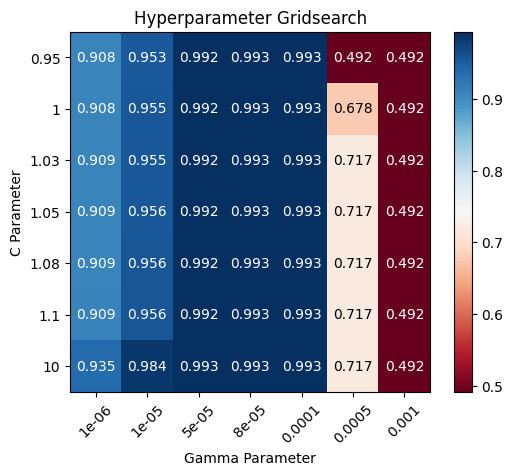

In [130]:

import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.4, right=0.99, bottom=0.4, top=1)
plt.imshow(
    scores,
    interpolation="nearest",
    cmap='RdBu',
)
plt.xlabel("Gamma Parameter")
plt.ylabel("C Parameter")
plt.colorbar()
plt.xticks(np.arange(len(gamma)), gamma, rotation=45)
plt.yticks(np.arange(len(C)), C)
for i in range(len(C)):
    for j in range(len(gamma)):
        if scores[i][j] >= 0.6 and scores[i][j] <= 0.8:
            c = 'black'
        else:
            c = 'white'
        plt.text(j, i, f'{scores[i][j]:.3f}', ha='center', va='center', color=c)
plt.title("Hyperparameter Gridsearch")
plt.show()

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [132]:
best_model = SVC(C=0.95, kernel='rbf', gamma=0.0001)
best_model.fit(x_train, y_train)

SVC(C=0.95, gamma=0.0001)

In [137]:
y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))

NameError: name 'y_test' is not defined